In [1]:
# Enable further imports

import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import matplotlib.pyplot as plt
import torch

from torch.nn import ModuleList, CrossEntropyLoss, Sequential
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import classification_report

from tqdm.notebook import tqdm

from data import BinaryColoredMNIST, BiasedCifar10

from models import MLPEncoder, ConvEncoder, Classifier, Adversary

from train import Trainer

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


### Data Modification

In [4]:
def generate_p_y_a(bias, C, K):
    if bias >= 1.0:
        raise ValueError("bias has to be in the interval [0, 1)")
        
    p_y_a = torch.zeros(K, C)

    for j in range(K):
        dominant_class = torch.randint(0, C, (1,)).item()
        
        uniform = torch.full((C,), 1.0 / C, device=device)
        
        one_hot = torch.zeros(C, device=device)
        one_hot[dominant_class] = 1.0
        
        p_y_a[j] = (1 - bias) * uniform + bias * one_hot

    return p_y_a

def entropy(p):
    mask = p > 0
    return -(p[mask] * torch.log2(p[mask])).sum()

def nmi(p_y_a, p_a):
    K, C = p_y_a.shape
    
    p_joint = p_a[:, None] * p_y_a
    p_y = p_joint.sum(dim=0)

    mi_matrix = torch.zeros_like(p_joint)
    ratio = p_y_a / p_y
    mi_matrix[p_joint > 0] = p_joint[p_joint > 0] * torch.log2(ratio[p_joint > 0])
    mi = mi_matrix.sum()

    H_y = entropy(p_y)
    H_a = entropy(p_a)

    nmi = mi / torch.sqrt(H_y * H_a) if H_y > 0 and H_a > 0 else torch.tensor(0.0)
    return nmi

In [5]:
data_dir = os.path.join(project_root, "data/mnist_data")
C = 2
K = 2

p_a = [0.1] * K
p_y_a = generate_p_y_a(0.75, C, K)

# train_set = BiasedCifar10(data_dir, p_y_a, p_a, device=device)
# test_set = BiasedCifar10(data_dir, generate_p_y_a(0.0, C, K), p_a, train=False, device=device)

train_set = BinaryColoredMNIST(data_dir, 0.8, 0.2, device=device)
test_set = BinaryColoredMNIST(data_dir, 0.5, 0.5, train=False, device=device)

print(f"NormalizedMutualInformation(Y; A) = {nmi(train_set.p_y_a, train_set.p_a):.4f}")

NormalizedMutualInformation(Y; A) = 0.2781


In [6]:
train_set, val_set = random_split(train_set, [0.8, 0.2])

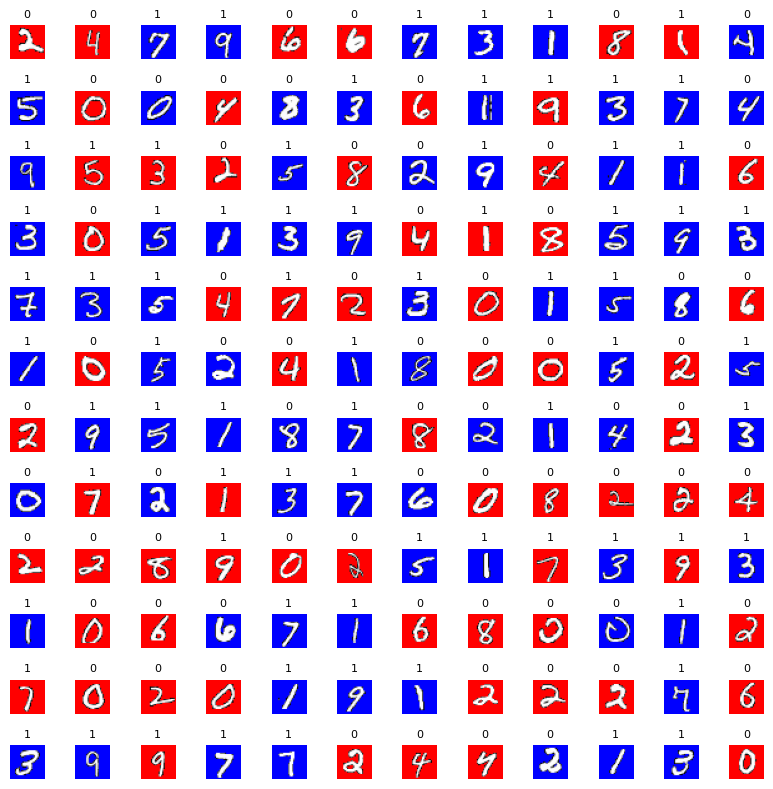

In [7]:
data = train_set[:144]

plt.figure(figsize=(8, 8))

for i, (img, a, label) in enumerate(zip(*data)):
    plt.subplot(12, 12, i + 1)
    plt.imshow(img.permute(1, 2, 0).cpu().numpy())
    plt.title(str(label.item()), fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [13]:
# Setup for DP
latent_dim = 24

batch_size = 256
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

# encoder = Sequential(
#     ConvEncoder(1200, image_dim=32),
#     MLPEncoder(latent_dim, in_dim=1200, output_neurons=(1024, 512, 256))
# )
encoder = MLPEncoder(latent_dim, output_neurons=(512, 256, 128, 64))
classifier = Classifier(latent_dim, C=C)
adversary = Adversary(latent_dim, K=K)

trainer = Trainer(train_loader, val_loader, encoder, classifier, adversary, C, K, device)

In [30]:
gamma = 4

learning_rate = 1e-3

criterion_class = CrossEntropyLoss()
optimizer_enc_class = Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=learning_rate, weight_decay=5e-4)
optimizer_adv = Adam(adversary.parameters(), lr=learning_rate, weight_decay=5e-4)

losses_enc, losses_adv = trainer.train(criterion_class, optimizer_enc_class, optimizer_adv, gamma, 10, True)

  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 1 (encoder+classifier loss: 0.1125, adversary loss: 0.2023)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 2 (encoder+classifier loss: -0.5228, adversary loss: 0.3289)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 3 (encoder+classifier loss: -0.5039, adversary loss: 0.4306)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 4 (encoder+classifier loss: -1.0926, adversary loss: 0.4489)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 5 (encoder+classifier loss: -1.0653, adversary loss: 0.3908)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 6 (encoder+classifier loss: 0.2193, adversary loss: 0.0506)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 7 (encoder+classifier loss: 0.2561, adversary loss: 0.0219)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 8 (encoder+classifier loss: 0.2086, adversary loss: 0.0028)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 9 (encoder+classifier loss: 0.1836, adversary loss: 0.0016)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 10 (encoder+classifier loss: 0.1626, adversary loss: 0.0010)


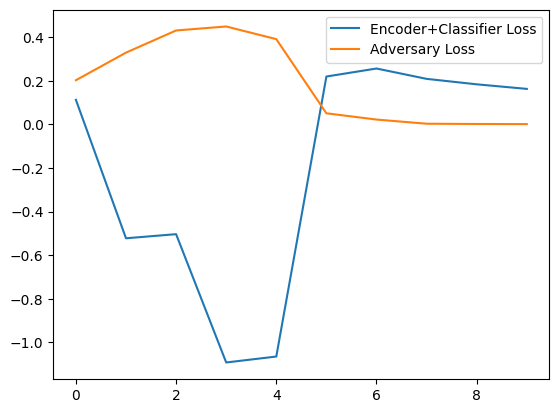

In [31]:
plt.plot(losses_enc, label="Encoder+Classifier Loss")
plt.plot(losses_adv, label="Adversary Loss")

plt.legend()
plt.show()

In [32]:
x, a_true, y_true = test_set[:]

z = encoder(x)

a_pred = trainer.pred_adversary(z, y_true).argmax(dim=1)
y_pred = classifier(z).argmax(dim=1)

# test_loader = tqdm(
#     DataLoader(test_set, batch_size=batch_size, shuffle=True),
#     unit="batch",
#     leave=False
# )

# y_pred = []
# y_true = []
# a_pred = []
# a_true = []

# for (x, a, y) in test_loader:
#     x = x.to(device)
#     a = a.to(device)
#     y = y.to(device)

#     z = encoder(x)
    
#     y_preds = classifier(z).argmax(dim=1)
#     a_preds = trainer.pred_adversary(z, y).argmax(dim=1)
    
#     a_pred.append(a_preds.cpu())
#     y_pred.append(y_preds.cpu())
    
#     a_true.append(a.cpu())
#     y_true.append(y.cpu())

# a_pred = torch.cat(a_pred, dim=0).numpy()
# a_true = torch.cat(a_true, dim=0).numpy()

# y_pred = torch.cat(y_pred, dim=0).numpy()
# y_true = torch.cat(y_true, dim=0).numpy()

In [33]:
a_pred = a_pred.cpu().numpy()
a_true = a_true.cpu().numpy()
y_pred = y_pred.cpu().numpy()
y_true = y_true.cpu().numpy()

print("Classifier:")
print(classification_report(y_true, y_pred, zero_division=0))

print()
print()

print("Adversary:")
print(classification_report(a_true, a_pred, zero_division=0))

Classifier:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91      4926
           1       0.89      0.93      0.91      5074

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



Adversary:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4996
           1       0.50      1.00      0.67      5004

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000

